# Setup

In [1]:
# Global Settings
SEED = 1
VERBOSE_LEVEL = 1
DIM = 768
DIM_RESIZE = 512
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 1

LR_MAX = 1e-4
LR_MIN = 1e-6
LR_START = 1e-5

FIND_LR = False
SAVE_OUTPUT = True
USE_TENSORBOARD = False

IMAGE_SIZE = [DIM, DIM]
IMAGE_RESIZE = [DIM_RESIZE, DIM_RESIZE]

In [2]:
%%capture
!pip install tensorflow_addons
!pip install efficientnet

In [3]:
import os
import re
import gc
import sys
import glob
import math
import json
import shutil
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from functools import partial
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from datetime import datetime, date
from pandas.core.common import flatten
from IPython.display import clear_output
from tensorflow.keras import backend as K


from IPython.display import Image
from tensorflow.keras.utils import plot_model

import efficientnet.keras as efn 

In [4]:
# cleanup
for f in glob.glob("/content/*.png"):
    os.remove(f)

for f in glob.glob("/content/*.hdf5"):
    os.remove(f)

for f in glob.glob("/content/*.txt"):
    os.remove(f)

for f in glob.glob("/content/*.h5"):
    os.remove(f)

for f in glob.glob("/content/*.json"):
    os.remove(f)

!rm -rf logs

In [5]:
%%capture
!rm -rf /content/melanoma-classification
!rm -rf /content/sample_data/

# if we do not have the data
if not os.path.exists("/content/melanoma-classification/README.md"):
    # install kaggle
    !pip install kaggle

    # get kaggle auth file
    path_to_auth_file = "kaggle.json"
    if not os.path.exists(path_to_auth_file):
        path_to_auth_file = '/content/drive/MyDrive/Colab Notebooks/_auth/kaggle.json'

    # read the kaggle.json file
    with open(path_to_auth_file) as json_file:
        data = json.load(json_file)
        os.environ['KAGGLE_USERNAME'] = data["username"]
        os.environ['KAGGLE_KEY'] = data["key"]

    # remove sample data so we have more space
    !rm -rf /content/sample_data

    # download kaggle dataset
    !kaggle datasets download -d saschamet/melanoma-1-12
    !unzip /content/melanoma-1-12.zip
    !rm /content/melanoma-1-12.zip

    ## pull repo
    !git clone https://github.com/SaschaMet/melanoma-classification.git

    ## update repo
    !cd melanoma-classification && git fetch && git pull

    ## switch branch and execute function
    !cd /content/melanoma-classification && git checkout "master" && git fetch && git reset --hard origin/master

In [6]:
# make sure the repo ist added to the sys path
sys.path.insert(0,'/content/melanoma-classification')
sys.path.insert(1,'/content/melanoma-classification/src')

In [7]:
# Tensorflow execution optimizations
# Source: https://www.tensorflow.org/guide/mixed_precision & https://www.tensorflow.org/xla
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
except:
    pass

if tpu:
    print("Try connecting to a tpu")
    try:
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
        # tf.config.experimental_connect_to_cluster(tpu)
        # tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        REPLICAS = strategy.num_replicas_in_sync
        print("REPLICAS:", REPLICAS)
    except ValueError as error:
        raise BaseException('An exception occurred: {}'.format(error))
    except BaseException as error:
        raise BaseException('An exception occurred: {}'.format(error))
else:
    num_gpus = len(
        tf.config.experimental.list_physical_devices('GPU')
    )
    print("Using default strategy for CPU and single GPU")
    print("Num GPUs Available: ", num_gpus)
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')
    strategy = tf.distribute.get_strategy()
    REPLICAS = strategy.num_replicas_in_sync
    print("REPLICAS:", REPLICAS)

INFO:tensorflow:Initializing the TPU system: grpc://10.41.124.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.41.124.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Try connecting to a tpu
Running on TPU  ['10.41.124.98:8470']
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


In [8]:
if tpu:
    BATCH_SIZE = 128  # increase the batch size if we have a tpu
    USE_TENSORBOARD = False # Tensorboard does not work with tpu

# Set needed env variables based on the global variables
os.environ["DIM"] = str(DIM)
os.environ["BATCH_SIZE"] = str(BATCH_SIZE)

# seed everything
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

# environment settings
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.4.1


In [9]:
%load_ext autoreload
%autoreload 2

# Custom imports
from model.evaluation import evaluate_model
from model.model_callbacks import get_model_callbacks
from model.LearningRateFinder import LearningRateFinder
from data.verify_tf_records import display_batch_of_images
from model.clr_callback import cyclic_learning_rate, get_lr_callback, plot_clr

In [10]:
## prevent colab shutdown 
%%javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

var connection = setInterval(ConnectButton, 60000);

function myStopFunction() {
    console.log("Remove interal"); 
    clearInterval(connection);
}

<IPython.core.display.Javascript object>

# Data Loading

In [11]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [12]:
MALIGNANT_IMAGES = tf.io.gfile.glob('gs://kds-dd07414d960d14a2a8849e3ab696a4cb3299162b439e521ac886f393/*.tfrec')
print("MALIGNANT TF Records", len(MALIGNANT_IMAGES))

# This files include all malginant images from 2020, 2019, 2018 and 2017 competition as well as data directly from ISIC
# Source: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/169139
MALIGNANT_IMAGES_V2 = tf.io.gfile.glob('gs://kds-77aee4ba270735bf8687a77209581d50b8710ff6486f134f19b29759/*train*.tfrec')[15:]
print("MALIGNANT TF Records V2", len(MALIGNANT_IMAGES_V2))

BENIGN_IMAGES = tf.io.gfile.glob('gs://kds-d499b3e548bc098dfea46bcac127fb30d0e465c2713c8457ff05deff/*.tfrec')
print("BENIGN TF Records", len(BENIGN_IMAGES))

BENIGN_IMAGES_TRAIN = BENIGN_IMAGES[0:160] # use only the first 160 batches for training

TEST_FILENAMES = tf.io.gfile.glob("gs://kds-3e36e1551f5588596f9fcb50129d35830a155849a24ad4825763d528/*.tfrec")
print("TEST TF Records", len(TEST_FILENAMES))

# Create the Training and Validation Dataset
print(" ")

## Training 
TRAINING_FILENAMES = [MALIGNANT_IMAGES[1], MALIGNANT_IMAGES[0]]
TRAINING_FILENAMES = TRAINING_FILENAMES + random.sample(MALIGNANT_IMAGES_V2, 20)
TRAINING_FILENAMES = TRAINING_FILENAMES + random.sample(BENIGN_IMAGES_TRAIN, len(TRAINING_FILENAMES))
np.random.shuffle(TRAINING_FILENAMES)

## Validation 
VALIDATION_FILENAMES = [
    MALIGNANT_IMAGES[2],
    BENIGN_IMAGES[162]
]

TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)

print("TRAINING FILES", len(TRAINING_FILENAMES))
print("VALODATION FILES", len(VALIDATION_FILENAMES))
print(" ")

print("TRAINING_IMAGES", TRAINING_IMAGES)
print("VALIDATION_IMAGES", VALIDATION_IMAGES)

MALIGNANT TF Records 3
MALIGNANT TF Records V2 45
BENIGN TF Records 163
TEST TF Records 55
 
TRAINING FILES 44
VALODATION FILES 2
 
TRAINING_IMAGES 6269
VALIDATION_IMAGES 384


In [13]:
AUGMENTATION_CONFIG = dict(
    # DATA AUGMENTATION
    rot = 180.0,
    shr = 1.5,
    hzoom = 6.0,
    wzoom = 6.0,
    hshift = 6.0,
    wshift = 6.0,
    
    # COARSE DROPOUT
    DROP_FREQ = 0, # Determines proportion of train images to apply coarse dropout to / Between 0 and 1.
    DROP_CT = 0, # How many squares to remove from train images when applying dropout.
    DROP_SIZE = 0, # The size of square side equals IMG_SIZE * DROP_SIZE / Between 0 and 1.  
)

def color(x):
    """Color augmentation
    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_saturation(x, 0.7, 1.7, seed=SEED)
    x = tf.image.random_brightness(x, 0.3, seed=SEED)
    x = tf.image.random_contrast(x, 0.5, 1.5, seed=SEED)
    return x

def flip(x):
    """Flip augmentation
    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x, seed=SEED)
    x = tf.image.random_flip_up_down(x, seed=SEED)
    return x

def rotate(x):
    """Rotation augmentation
    Args:
        x: Image

    Returns:
        Augmented image
    """
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))


def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))
    

def transform(image, cfg=AUGMENTATION_CONFIG):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = DIM_RESIZE
    XDIM = DIM%2 #fix for size 331
    
    rot = cfg['rot'] * tf.random.normal([1], dtype='float32')
    shr = cfg['shr'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['hzoom']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['wzoom']
    h_shift = cfg['hshift'] * tf.random.normal([1], dtype='float32') 
    w_shift = cfg['wshift'] * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift)

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM_RESIZE, DIM_RESIZE,3])

In [14]:
def augment_image(image, augment=True):  
    augmentations = [transform, color, rotate, flip] 
    if augment:
        # Data augmentation
        for f in augmentations:
            if random.randint(1, 10) >= 5:
                image = f(image)         
    return image

In [15]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    return image

In [16]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
resizing_layer = tf.keras.layers.experimental.preprocessing.Resizing(DIM_RESIZE, DIM_RESIZE)

In [17]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

In [18]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.cache() # cache ds for performance gains
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE) # normalize the image so the values are between 0 and 255
    dataset = dataset.map(lambda x, y: (resizing_layer(x), y), num_parallel_calls=AUTOTUNE) # resize the images to the same height and width

    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [19]:
def get_training_dataset(augment):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    if augment:
        dataset = dataset.map(lambda x, y: (augment_image(x, augment=augment), y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(TRAINING_IMAGES * 2, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [20]:
def get_validation_dataset(ordered=False, repeat=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [21]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# Data Validation

In [22]:
example_dataset = get_training_dataset(augment=False)
example_dataset = example_dataset.unbatch().batch(15)

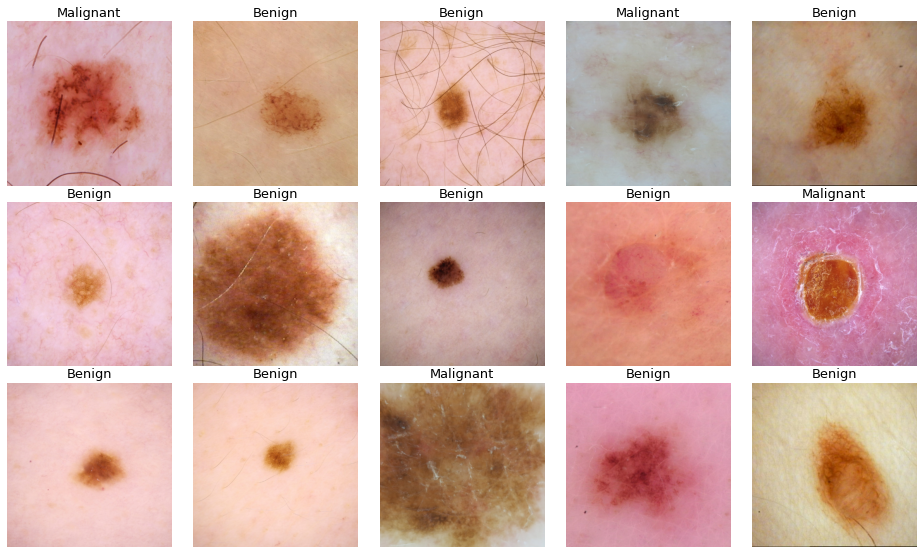

In [23]:
example_batch = iter(example_dataset) 
image_batch, label_batch = next(example_batch)
display_batch_of_images((image_batch, label_batch))

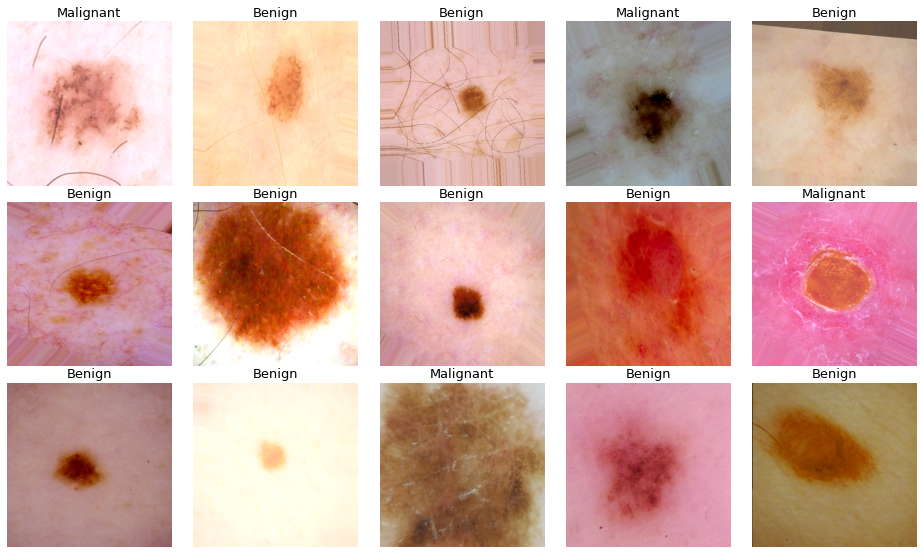

In [24]:
augmented_images = [augment_image(x, augment=True) for x in image_batch]
augmented_images = [np.clip(x, 0, 1) for x in augmented_images]
labels = [l.numpy() for l in label_batch]
display_batch_of_images((augmented_images, labels), unbatched=True)

In [25]:
# images are in float32 format with normalized values
for i in range(10):
    image = image_batch[i]
    print("min:", np.min(image), " -  max:", np.max(image))

print(image.dtype)

min: 0.0  -  max: 0.91421574
min: 0.06911765  -  max: 0.9188726
min: 0.047303926  -  max: 0.98259807
min: 0.1637255  -  max: 0.81960785
min: 0.0  -  max: 0.7877452
min: 0.07549019  -  max: 0.9911765
min: 0.0007352942  -  max: 1.0
min: 0.0  -  max: 0.87794125
min: 0.22843139  -  max: 0.9906863
min: 0.033333335  -  max: 1.0
<dtype: 'float32'>


In [26]:
# Iterate over n batches to get the class distribution
benign_cases = 0
malignant_cases = 0

for i in range(0, 50):
    x,y = next(example_batch)
    for label in y.numpy():
        if int(label) == 0:
            benign_cases = benign_cases + 1
        else:
            malignant_cases = malignant_cases + 1


initial_bias = np.log([malignant_cases/benign_cases])

weight_for_0 = (1 / benign_cases)*(TRAINING_IMAGES)/2.0 
weight_for_1 = (1 / malignant_cases)*(TRAINING_IMAGES)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("benign_cases", benign_cases)
print("malignant_cases", malignant_cases)
print("ratio", round(malignant_cases / benign_cases, 2))
print("initial_bias", initial_bias)

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

benign_cases 523
malignant_cases 227
ratio 0.43
initial_bias [-0.83463145]
Weight for class 0: 5.99
Weight for class 1: 13.81


# Model Creation

In [27]:
training_dataset = get_training_dataset(augment=True)
validation_dataset = get_validation_dataset(repeat=True)

steps_per_epoch = 30
validation_steps_per_epoch = 5

print("Epochs", EPOCHS)
print("BATCH SIZE", BATCH_SIZE)

print("Train images", count_data_items(TRAINING_FILENAMES))
print("Validation images", count_data_items(VALIDATION_FILENAMES))

print("steps_per_epoch", steps_per_epoch)
print("validation_steps_per_epoch", validation_steps_per_epoch)

Epochs 100
BATCH SIZE 128
Train images 6269
Validation images 384
steps_per_epoch 30
validation_steps_per_epoch 5


In [28]:
def get_model_parameters(steps_per_epoch, lr, epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = 'binary_crossentropy'
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
    ]

    return loss, metrics, optimizer

In [29]:
def compile_model(model):
    loss, metrics, optimizer = get_model_parameters(steps_per_epoch, LR_START, EPOCHS)
    if tpu:
        model.compile(
            loss=loss,
            metrics=metrics,
            optimizer=optimizer,
            # Reduce python overhead, and maximize the performance of your TPU
            # Anything between 2 and `steps_per_epoch` could help here.
            steps_per_execution=int(steps_per_epoch / 10),
        )
    else:
        model.compile(
            loss=loss,
            metrics=metrics,
            optimizer=optimizer,
        )

    return model


def reset_model():
    model = tf.keras.models.load_model("stage_0.h5")
    model.load_weights("stage_0.hdf5")
    return model


def fine_tune_model(model, from_layer = 5):
    print('trainable layers before', len(model.trainable_weights))
    base_model.trainable = True
    set_trainable = False
    for layer in model.layers:
        if "efficientnet" in layer.name:
            for layer in layer.layers:
                if str(from_layer) in layer.name:
                    set_trainable = True
                if set_trainable and not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
                else:
                    layer.trainable = False
    print('trainable layers after', len(model.trainable_weights))
    return model

In [30]:
# Clear the session - this helps when we are creating multiple models
K.clear_session()

# Creating the model in the strategy scope places the model on the TPU
with strategy.scope():
    base_model = efn.EfficientNetB6(
        include_top=False, 
        weights="imagenet",
        input_shape=(DIM_RESIZE, DIM_RESIZE, 3),
    )
    base_model.trainable = False

    if initial_bias is not None:
        output_bias = tf.keras.initializers.Constant(initial_bias)

    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid', bias_initializer=output_bias)
    ])

    model = compile_model(model)

165527552/165527152 [==============================] - 2s 0us/step


In [31]:
#plot_model(base_model, show_shapes=True)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 16, 16, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 18440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 40,978,585
Trainable params: 18,449
Non-trainable params: 40,960,136
_________________________________________________________________


# Initial Model Training

In [33]:
history = model.fit(
    training_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps_per_epoch,
    class_weight=class_weight,
    verbose=VERBOSE_LEVEL
)

Epoch 1/10
30/30 [==============================] - 133s 4s/step - loss: 6.2188 - accuracy: 0.7103 - auc: 0.4747 - val_loss: 0.8055 - val_accuracy: 0.4250 - val_auc: 0.5213
Epoch 2/10
30/30 [==============================] - 17s 554ms/step - loss: 6.1877 - accuracy: 0.7074 - auc: 0.4827 - val_loss: 0.7922 - val_accuracy: 0.4250 - val_auc: 0.5251
Epoch 3/10
30/30 [==============================] - 16s 526ms/step - loss: 5.8783 - accuracy: 0.7245 - auc: 0.4870 - val_loss: 0.7812 - val_accuracy: 0.4250 - val_auc: 0.5208
Epoch 4/10
30/30 [==============================] - 16s 526ms/step - loss: 6.1849 - accuracy: 0.6875 - auc: 0.5274 - val_loss: 0.7683 - val_accuracy: 0.4266 - val_auc: 0.5204
Epoch 5/10
30/30 [==============================] - 16s 520ms/step - loss: 5.6912 - accuracy: 0.7235 - auc: 0.5610 - val_loss: 0.7603 - val_accuracy: 0.4266 - val_auc: 0.5177
Epoch 6/10
30/30 [==============================] - 16s 536ms/step - loss: 5.7761 - accuracy: 0.7119 - auc: 0.5796 - val_loss: 

In [34]:
# save the initially trained model, so we can restore it later
model.save_weights("stage_0.hdf5")
model.save("stage_0.h5")

# Learning Rate Finder

In [35]:
if FIND_LR:
    K.clear_session()
    with strategy.scope():
        print("Current LR Min", LR_MIN)
        print("Current LR Max", LR_MAX)

        model = reset_model()
        model = fine_tune_model(model, 2)
        model = compile_model(model)

        lrf = LearningRateFinder(model)
        lrf.find(
            training_dataset, 
            startLR=1e-10, 
            endLR=1e-1,
            epochs=30,
            stepsPerEpoch=steps_per_epoch, 
            batchSize=64,
            verbose=1
        )

In [36]:
if FIND_LR:
    lrf.plot_loss()
    !rm -rf /content/lr.hdf5
    sys.exit(0)

# Fine Tuning

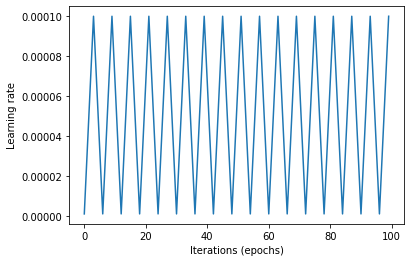

In [37]:
mode='triangular'
step_size=3.
clr_callback = get_lr_callback(mode, LR_MIN, LR_MAX, step_size)
plot_clr(mode, LR_MIN, LR_MAX, step_size, EPOCHS)

# callbacks = get_model_callbacks(VERBOSE_LEVEL, SAVE_OUTPUT, timestamp)
clr_callback = get_lr_callback(mode, LR_MIN, LR_MAX, step_size)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

callbacks = [clr_callback, early_stopping_cb]

In [38]:
K.clear_session()
with strategy.scope():
    if FIND_LR: # reset the model if we searched for learning rates
        model = reset_model()
    model.trainable = True
    model = compile_model(model)

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 16, 16, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 18440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 40,978,585
Trainable params: 40,754,153
Non-trainable params: 224,432
_________________________________________________________________


In [40]:
history = model.fit(
    training_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps_per_epoch,
    class_weight=class_weight,
    verbose=VERBOSE_LEVEL
)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999974752427e-07.
30/30 [==============================] - 321s 11s/step - loss: 6.3390 - accuracy: 0.7012 - auc: 0.5276 - val_loss: 0.7391 - val_accuracy: 0.4297 - val_auc: 0.5763
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 3.4000004234258085e-05.
30/30 [==============================] - 33s 1s/step - loss: 5.8571 - accuracy: 0.7159 - auc: 0.6923 - val_loss: 0.7788 - val_accuracy: 0.4250 - val_auc: 0.6242
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 6.700000812998042e-05.
30/30 [==============================] - 33s 1s/step - loss: 3.7655 - accuracy: 0.8513 - auc: 0.9021 - val_loss: 0.8428 - val_accuracy: 0.4344 - val_auc: 0.6240
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
30/30 [==============================] - 32s 1s/step - loss: 3.0437 - accuracy: 0.8599 - auc: 0.9248 - val_loss: 0.9197 - val_

# Model Evaluation

start predicting ...
Precision: 0.7902
Recall: 0.8804
Threshold: 0.1574
F1 Score: 0.8329


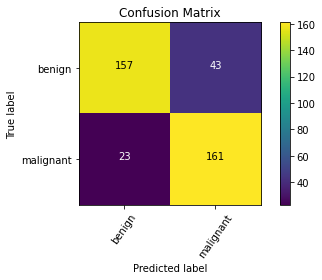

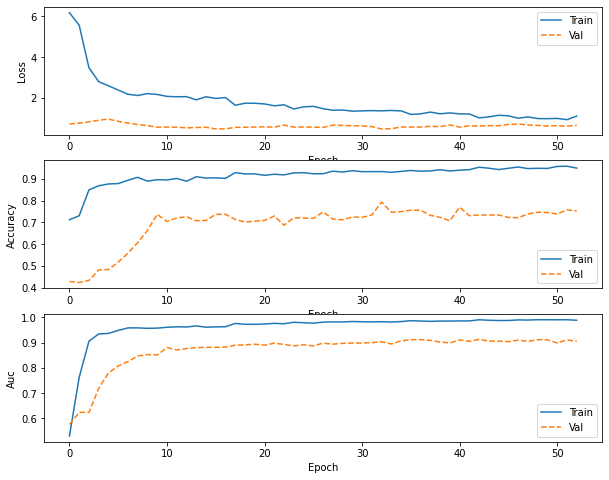

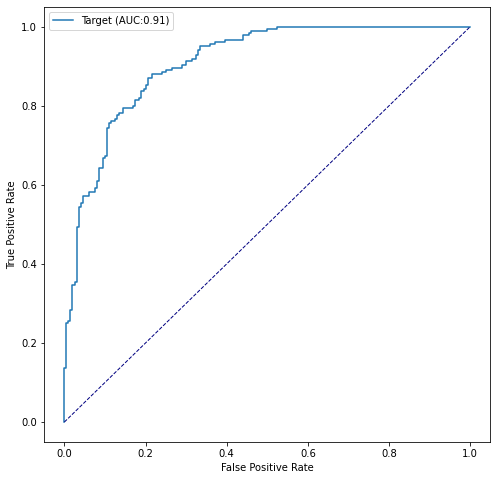

In [41]:
example_validation_dataset = get_validation_dataset()
predictions, labels, threshold = evaluate_model(
    model=model, 
    dataset=example_validation_dataset, 
    history=history,
    save_output=SAVE_OUTPUT, 
    timestamp=timestamp
)

# GH & Submission

In [42]:
%%capture
import os.path
from os import path

if not path.exists("/content/current_metrics.txt"):
    # download the current metrics
    !wget https://raw.githubusercontent.com/SaschaMet/melanoma-classification/master/evaluation/metrics.txt
    !mv /content/metrics.txt.1 /content/current_metrics.txt

In [43]:
print("current metrics")
with open("/content/current_metrics.txt") as json_file:
    current_metrics = json.load(json_file)
print(current_metrics)

current metrics
{'f1score': '0.8199', 'precision': '0.7269', 'recall': '0.9402', 'threshold': '0.2299'}


In [44]:
print("new metrics")
with open("/content/metrics.txt") as json_file:
    metrics = json.load(json_file)
print(metrics)

new metrics
{'f1score': '0.8329', 'precision': '0.7902', 'recall': '0.8804', 'threshold': '0.1574'}


In [45]:
# check if the new model is better than the old one
is_better = True

# if one metric is worse than a metric from the prev model, do not update the model
metrics_to_compare = ['f1score', 'precision', 'recall']
for metric in metrics_to_compare:
    if metrics[metric] < current_metrics[metric]:
        is_better = False

print("New model is an improvement compared to the pre model:", is_better)

New model is an improvement compared to the pre model: False


In [46]:
#if not is_better:
    #sys.exit("Stop execution because of inferior model")

In [47]:
## save the model
model.save_weights("final_weights.hdf5")
model.save("final_model.h5")

In [48]:
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('model.json', 'w') as json_file:
    json_file.write(json_model)

In [49]:
# create a new model for the predictions
#K.clear_session()
#with strategy.scope():
    #model = tf.keras.models.load_model("/content/final_model.h5")
    #model.load_weights("final_weights.hdf5")
    #model = compile_model(model)

In [50]:
test_ds = get_test_dataset(ordered=True)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

In [51]:
print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds, verbose=1, steps=math.ceil(len(test_ids) / BATCH_SIZE))

Computing predictions...
86/86 [==============================] - 69s 800ms/step


In [52]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

Generating submission.csv file...


,image_name,target
0,ISIC_0052060,0.064946
1,ISIC_0297702,0.000783
2,ISIC_0479726,0.049854
3,ISIC_0641371,0.017003
4,ISIC_0808861,0.039199


In [53]:
pred_df.to_csv("./submission.csv", index=False)
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m "Sub Effnet B6"

100% 268k/268k [00:01<00:00, 193kB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification

In [54]:
sys.exit("")

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [55]:
## if the model is an improvement, push it!
!cd /content/melanoma-classification && git checkout -b effnetb6 && git reset --hard origin/effnetb6

Switched to a new branch 'effnetb6'
HEAD is now at ed0efa6 effnetb6


In [56]:
!mkdir evaluation

for f in glob.glob("/content/*auc.png"):
    os.rename(f, "auc.png")

for f in glob.glob("/content/*cm.png"):
    os.rename(f, "cm.png")

for f in glob.glob("/content/*history.png"):
    os.rename(f, "history.png")
    
shutil.move("/content/model.json", "/content/evaluation/model.json")
shutil.move("/content/final_model.h5", "/content/evaluation/model.hdf5")
shutil.move("/content/history.png", "/content/evaluation/history.png")
shutil.move("/content/cm.png", "/content/evaluation/cm.png")
shutil.move("/content/auc.png", "/content/evaluation/auc.png")
shutil.move("/content/metrics.txt", "/content/evaluation/metrics.txt")
shutil.move("/content/current_metrics.txt", "/content/evaluation/current_metrics.txt")

!rm -rf /content/melanoma-classification/evaluation
!mv /content/evaluation /content/melanoma-classification/evaluation

In [57]:
gh_auth = "/content/drive/MyDrive/Colab Notebooks/_auth/gh_auth.txt"
with open(gh_auth) as f:
    gh_auth = f.read()

!cd /content/melanoma-classification && git config --global user.email "sascha.metzger@outlook.com"
!cd /content/melanoma-classification && git config --global user.name "SaschaMet"

!cd /content/melanoma-classification && git remote remove origin
!cd /content/melanoma-classification && git remote add origin $gh_auth

In [58]:
!cd /content/melanoma-classification && git fetch && git checkout effnetb6 && git status

From https://github.com/SaschaMet/melanoma-classification
 * [new branch]      effnet       -> origin/effnet
 * [new branch]      effnetb6     -> origin/effnetb6
 * [new branch]      master       -> origin/master
 * [new branch]      new-training -> origin/new-training
 * [new branch]      v-analytics  -> origin/v-analytics
 * [new branch]      xception     -> origin/xception
M	evaluation/auc.png
M	evaluation/cm.png
M	evaluation/history.png
M	evaluation/metrics.txt
M	evaluation/model.json
Already on 'effnetb6'
On branch effnetb6
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   evaluation/auc.png
	modified:   evaluation/cm.png
	modified:   evaluation/history.png
	modified:   evaluation/metrics.txt
	modified:   evaluation/model.json

no changes added to commit (use "git add" and/or "git commit -a")


In [59]:
!cd /content/melanoma-classification && git checkout effnetb6
!cd /content/melanoma-classification && git add .
!cd /content/melanoma-classification && git commit -m "effnetb6"
!cd /content/melanoma-classification && git push --set-upstream origin effnetb6

M	evaluation/auc.png
M	evaluation/cm.png
M	evaluation/history.png
M	evaluation/metrics.txt
M	evaluation/model.json
Already on 'effnetb6'
[effnetb6 5b1d9fc] effnetb6
 5 files changed, 2 insertions(+), 2 deletions(-)
 rewrite evaluation/auc.png (99%)
 rewrite evaluation/cm.png (98%)
 rewrite evaluation/history.png (99%)
Counting objects: 8, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 70.53 KiB | 17.63 MiB/s, done.
Total 8 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/SaschaMet/melanoma-classification.git
   ed0efa6..5b1d9fc  effnetb6 -> effnetb6
Branch 'effnetb6' set up to track remote branch 'effnetb6' from 'origin'.


In [60]:
!cd /content/melanoma-classification && git status

On branch effnetb6
Your branch is up to date with 'origin/effnetb6'.

nothing to commit, working tree clean
